# ⚙️ Part 4: Supervised & Embedding models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
import os

sys.path.append(os.path.abspath('..'))
from analyze_results import visualize_classification_report, compare_models_metrics

# Supervised


## Random Forest analysis

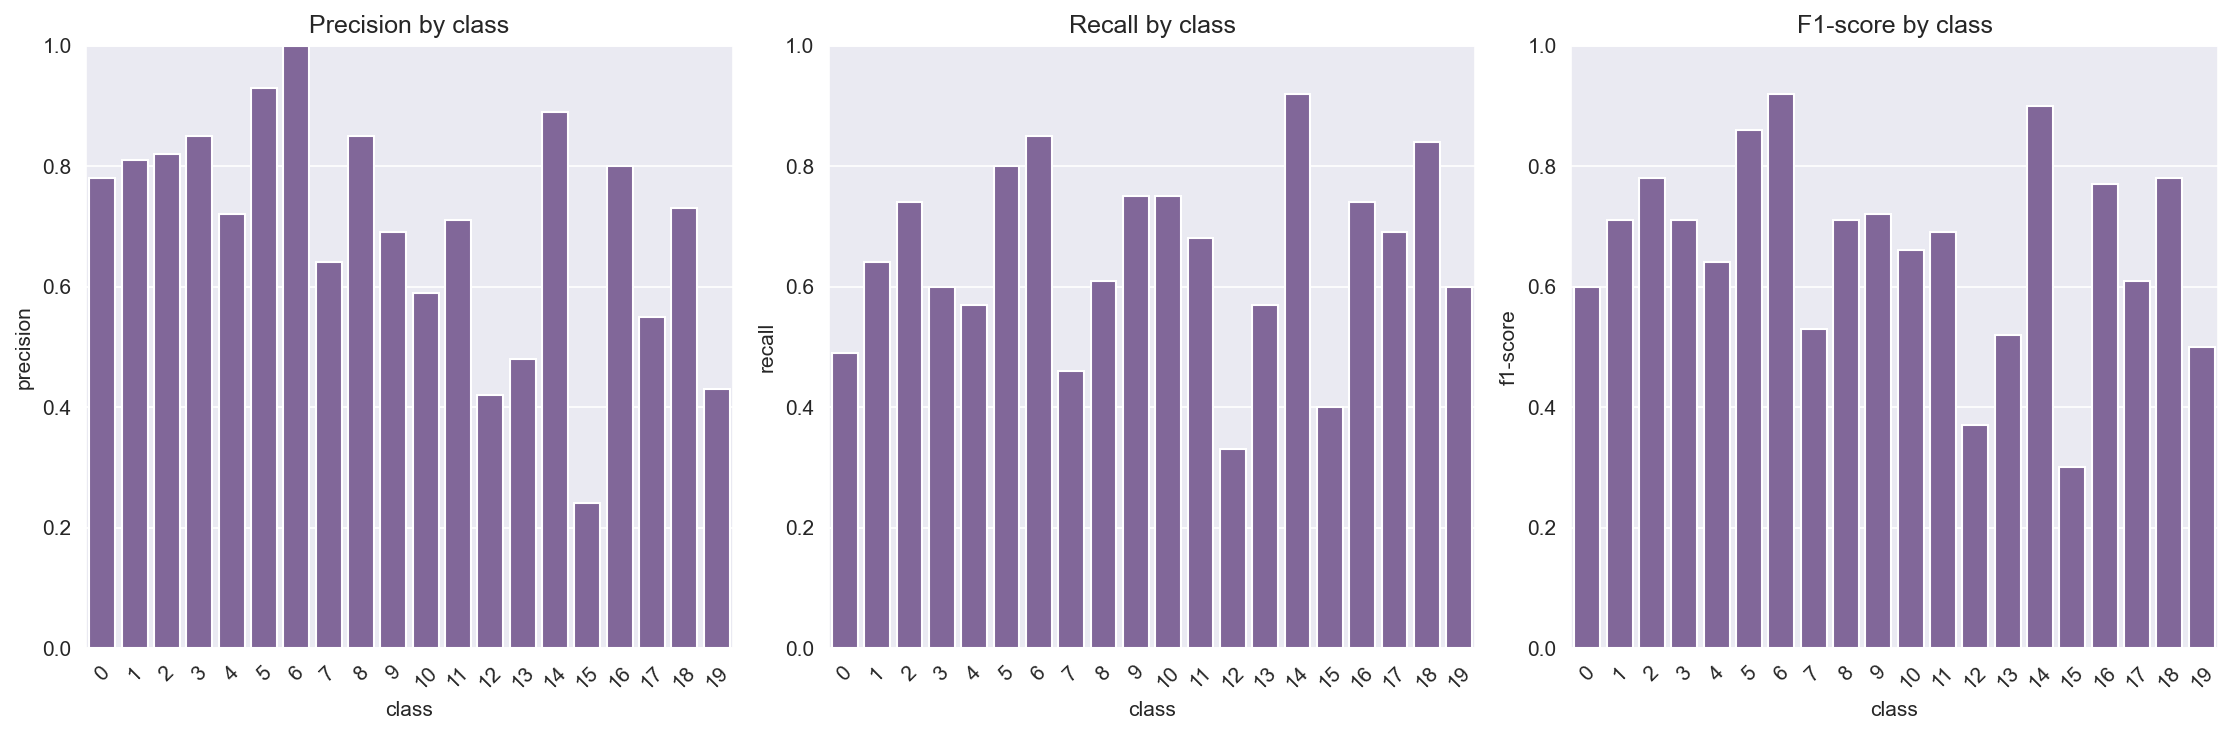

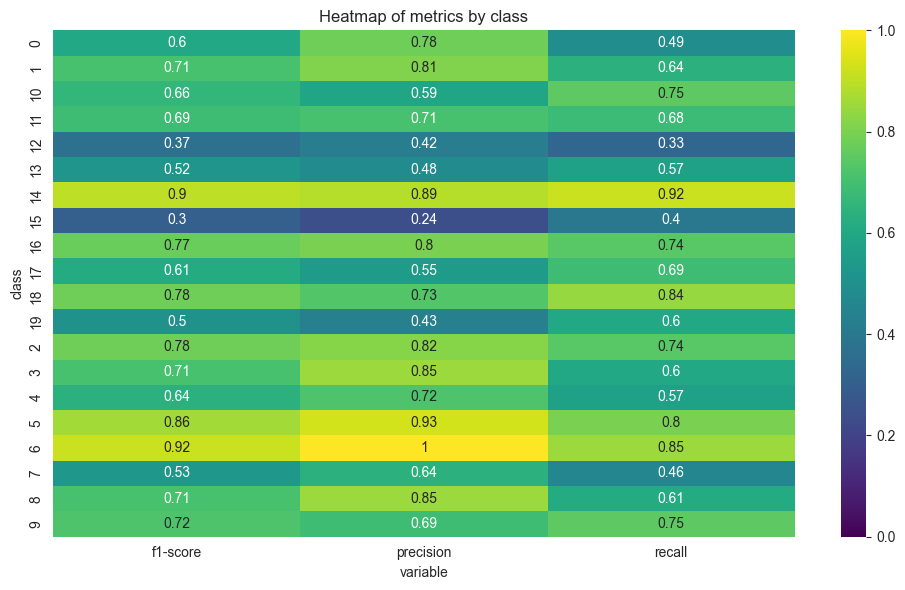


Average values of metrics:
precision    0.6965
recall       0.6515
f1-score     0.6640
dtype: float64


In [2]:
# Call analysis function for random forest model
random_forest_path = '../outputs/reports/classification_report_random_forest_20250602_113405.txt'
random_forest_metrics = visualize_classification_report(random_forest_path)

## XG Boost 

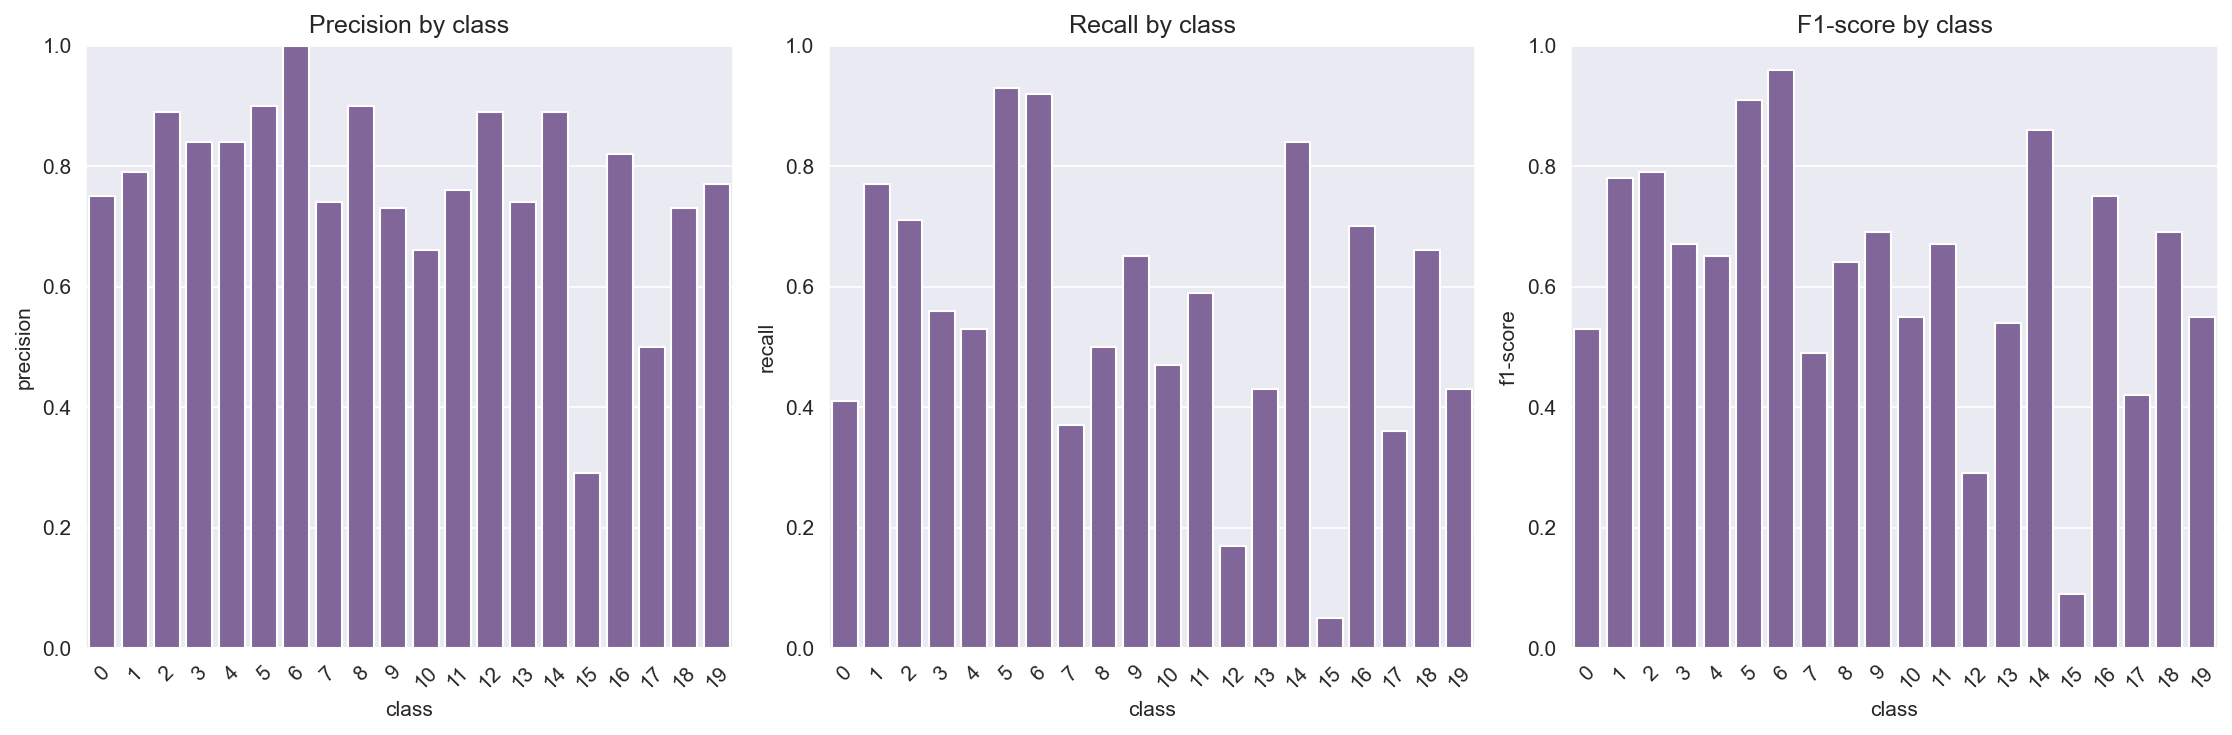

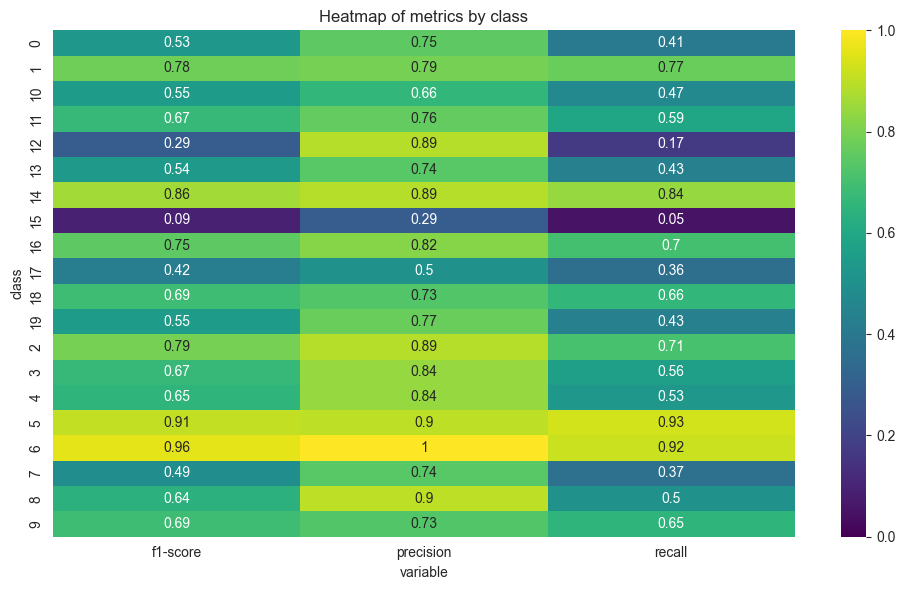


Average values of metrics:
precision    0.7715
recall       0.5525
f1-score     0.6260
dtype: float64


In [3]:
# Call analysis function for xg boost model
xg_boost_path = '../outputs/reports/classification_report_xgboost_20250602_114445.txt'
xg_boost_metrics = visualize_classification_report(xg_boost_path)

## Logistic Regression

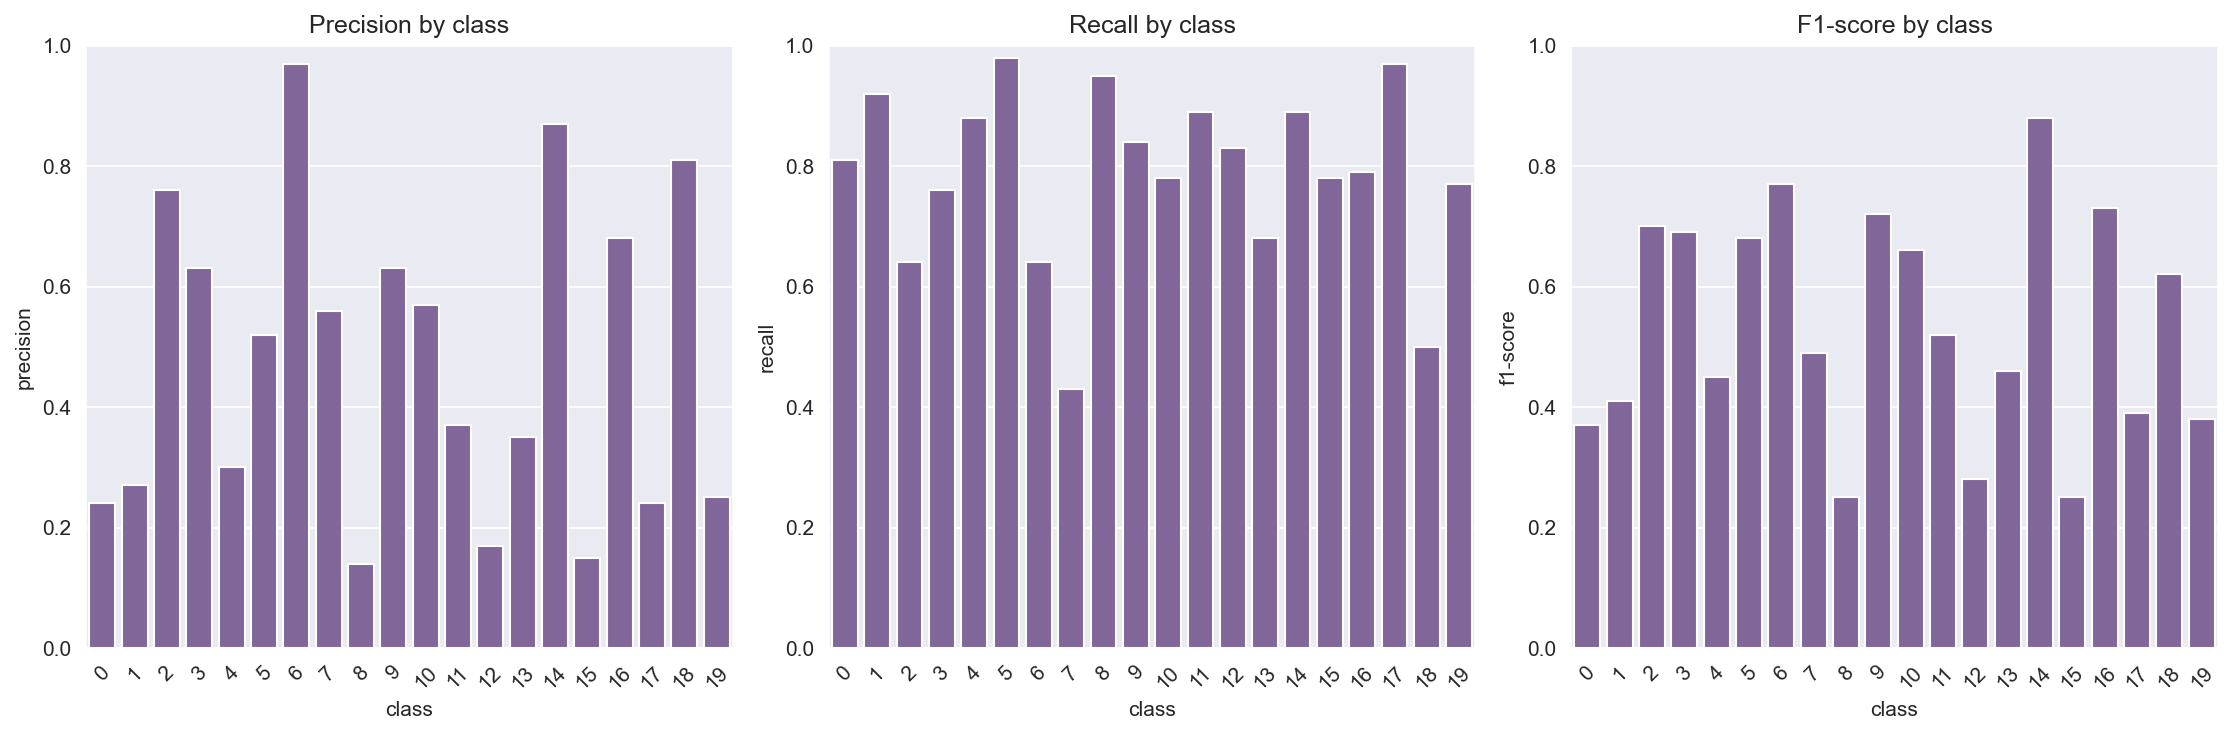

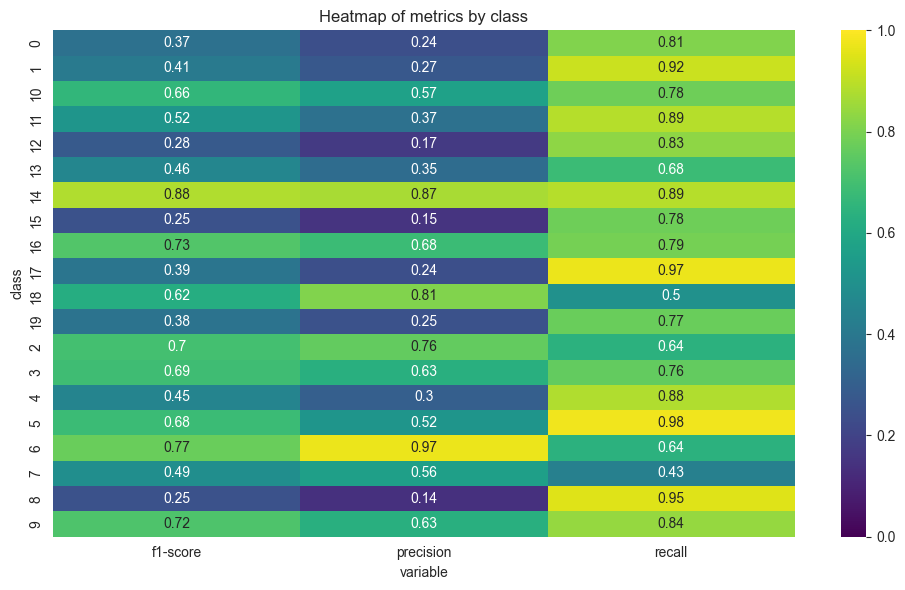


Average values of metrics:
precision    0.4740
recall       0.7865
f1-score     0.5350
dtype: float64


In [4]:

# Call analysis function for logistic regression model
logistic_regression_path = '../outputs/reports/classification_report_logreg_20250602_113506.txt'
logistic_regression_metrics = visualize_classification_report(logistic_regression_path)

## Supervised models comparaison 

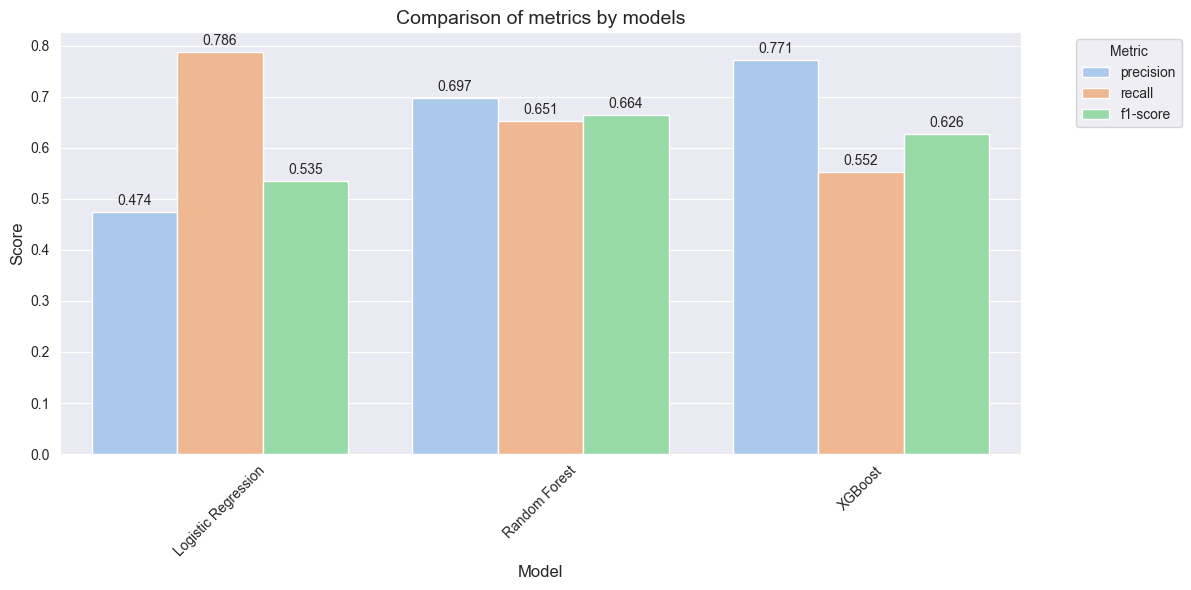

In [5]:
model_dfs = {
    'Logistic Regression': logistic_regression_metrics,
    'Random Forest': random_forest_metrics,
    'XGBoost': xg_boost_metrics
}

df_comparison = compare_models_metrics(model_dfs)

# Embedding

## BERT

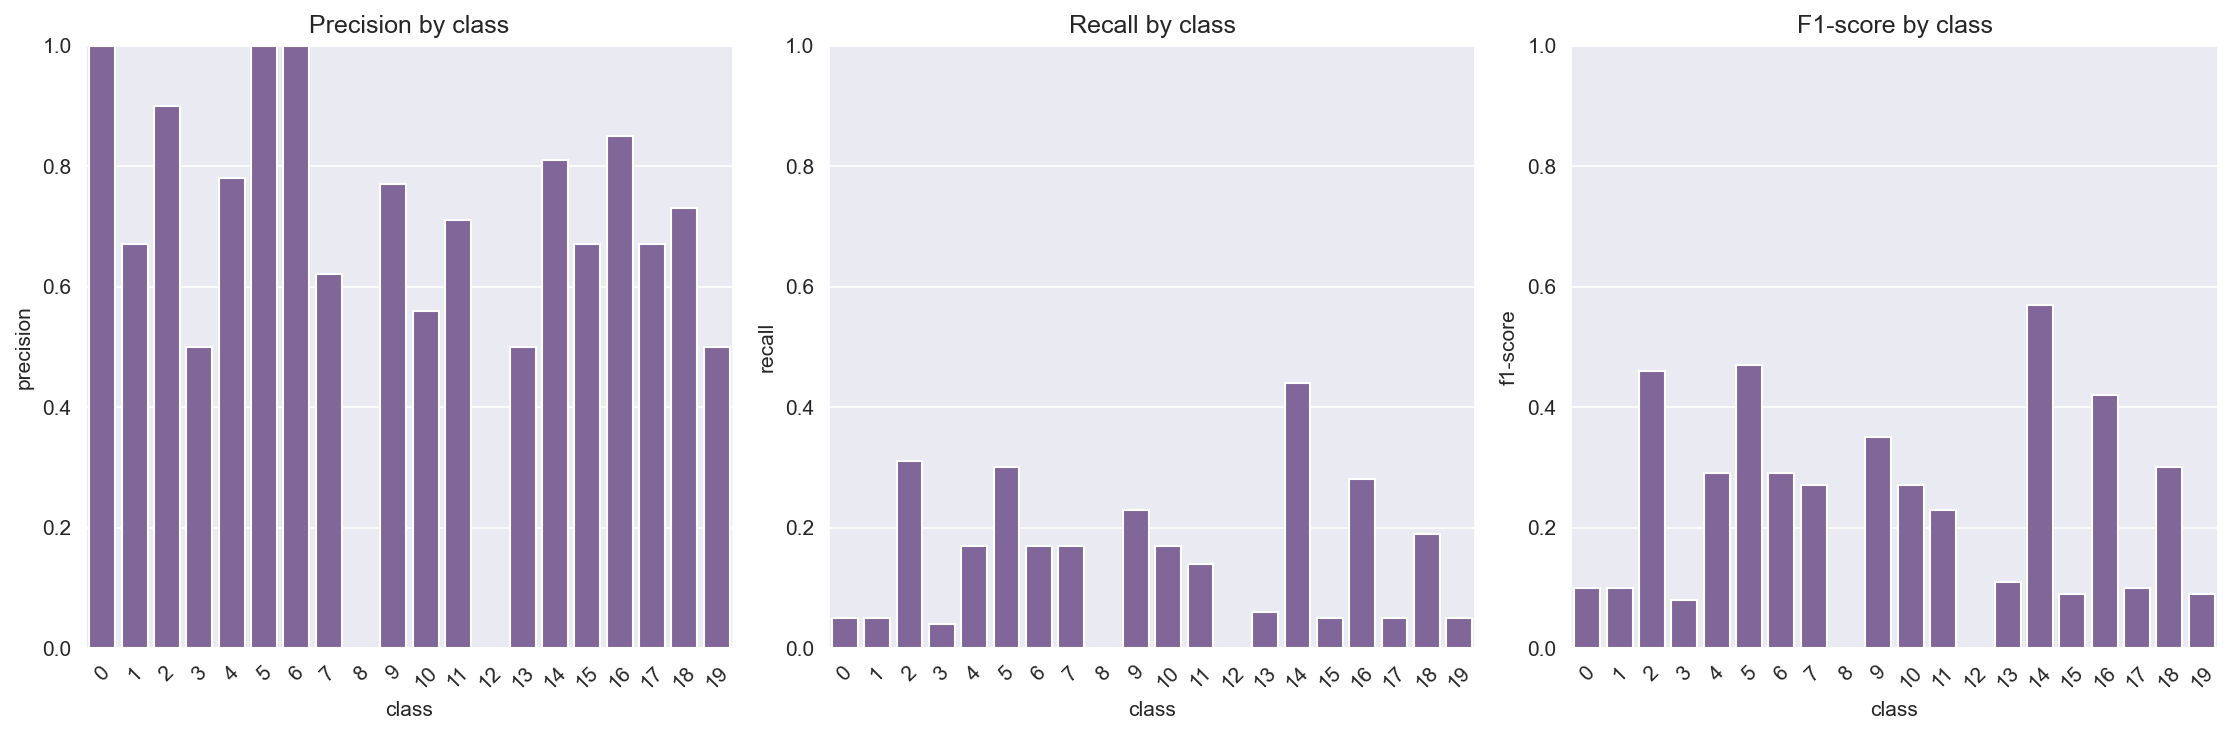

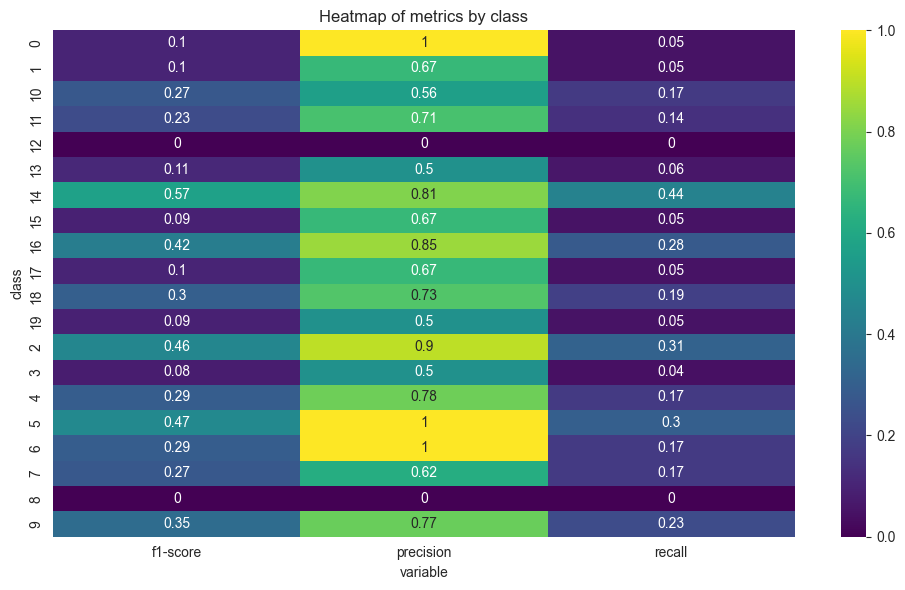


Average values of metrics:
precision    0.6620
recall       0.1460
f1-score     0.2295
dtype: float64


In [6]:
bert_path = '../outputs/reports/classification_report_bert_20250603_111009.txt'
bert_metrics = visualize_classification_report(bert_path)

## USE

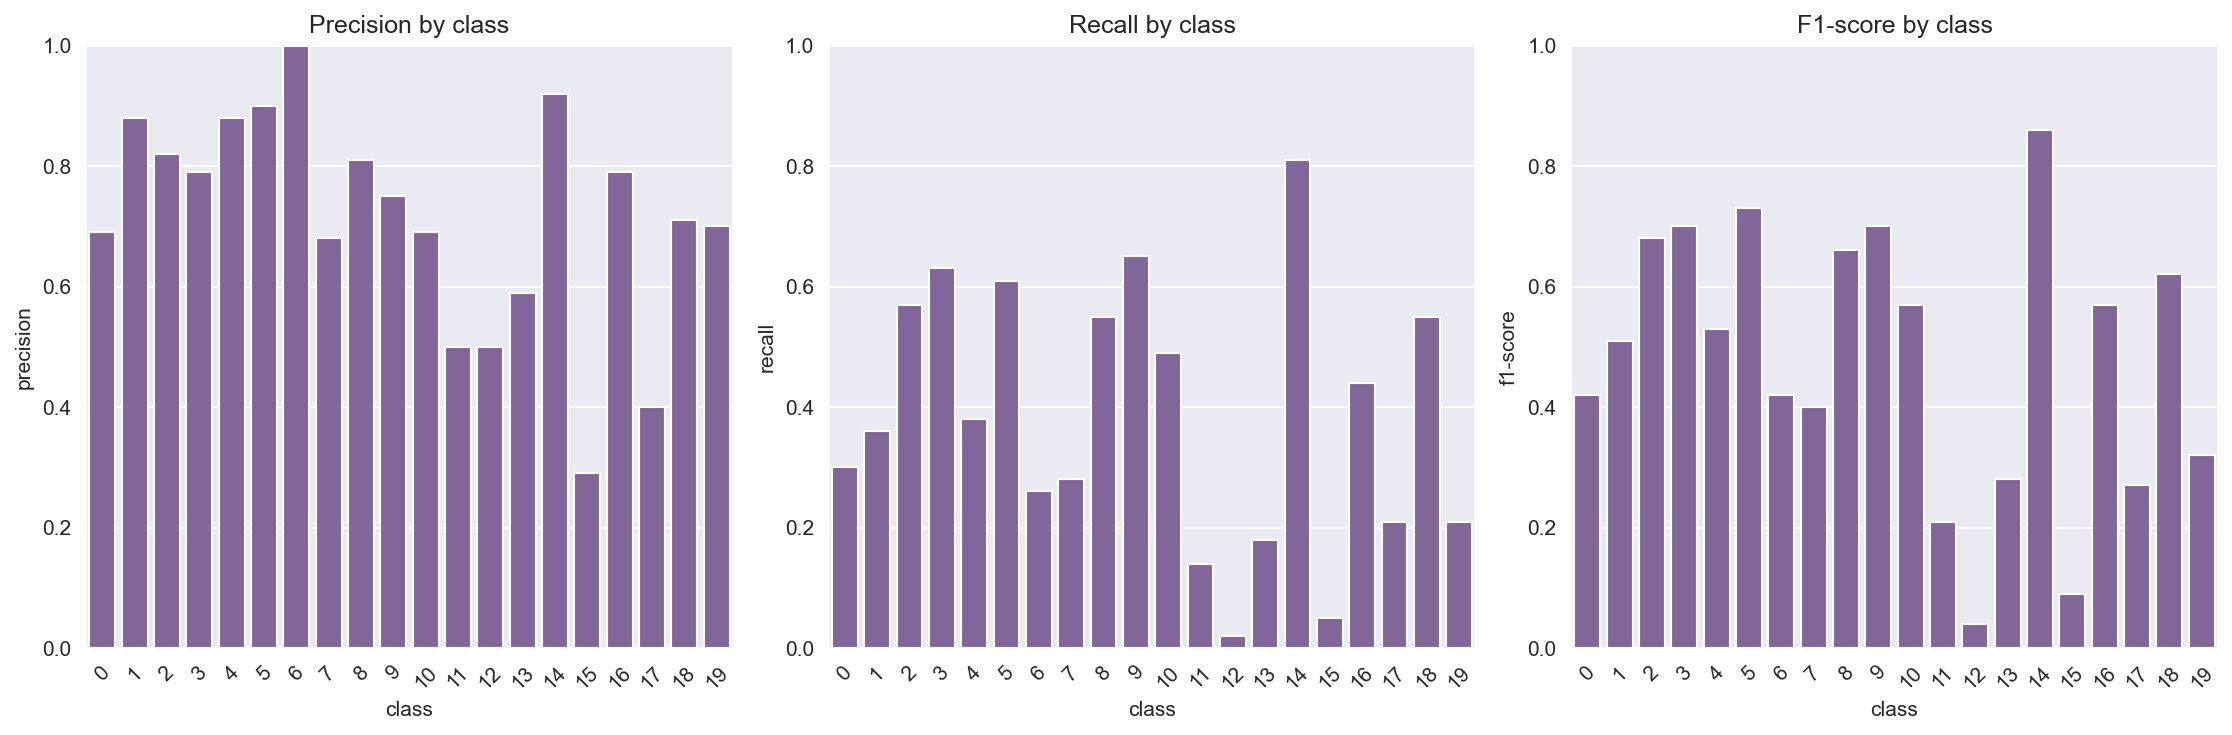

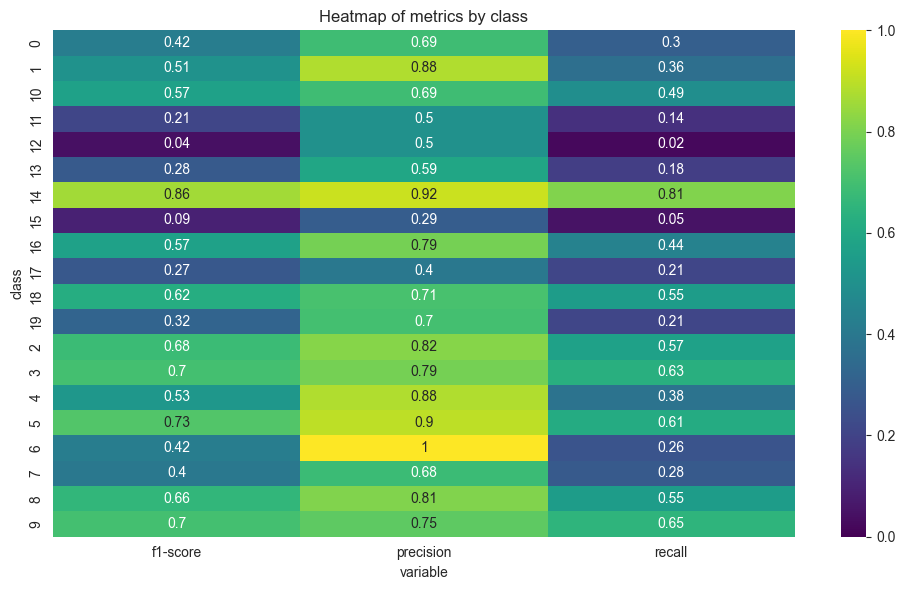


Average values of metrics:
precision    0.7145
recall       0.3845
f1-score     0.4790
dtype: float64


In [7]:
use_path = '../outputs/reports/classification_report_use_20250603_105601.txt'
use_metrics = visualize_classification_report(use_path)

## Word2Vec

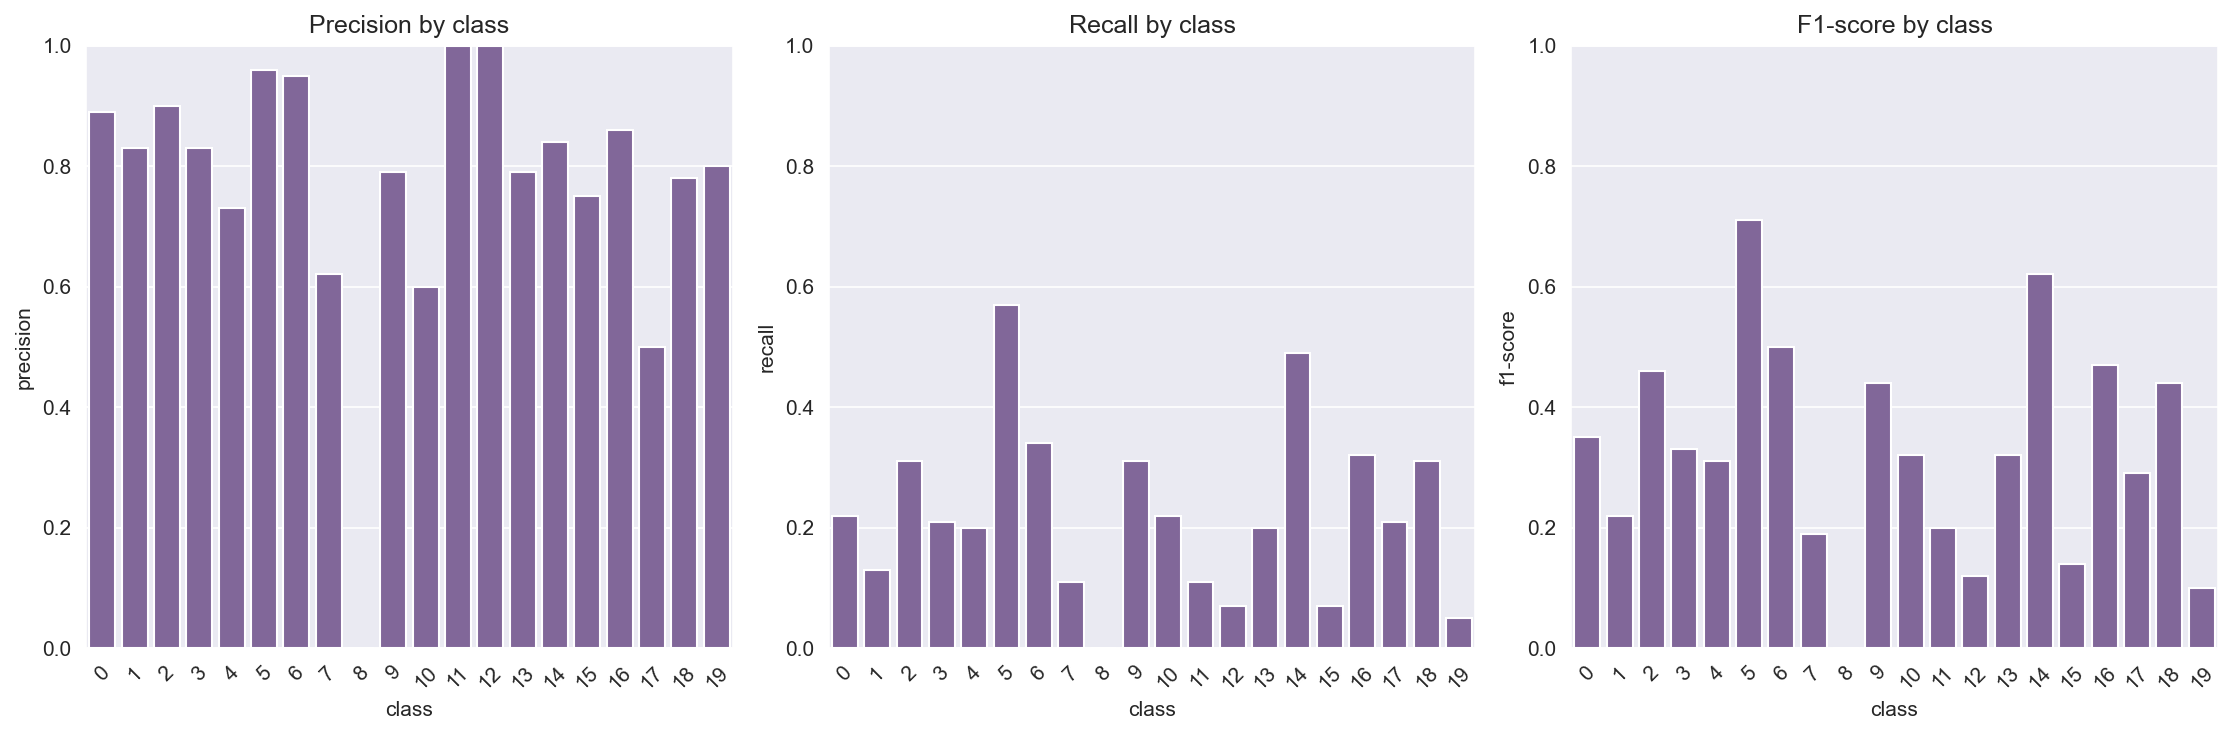

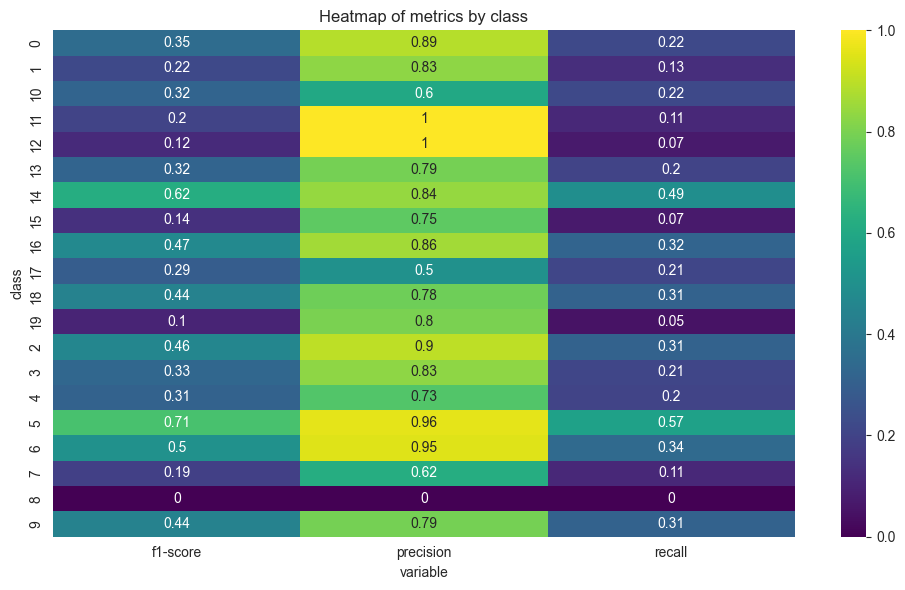


Average values of metrics:
precision    0.7710
recall       0.2225
f1-score     0.3265
dtype: float64


In [8]:
word_path = '../outputs/reports/classification_report_word2vec_20250603_112233.txt'
word_metrics = visualize_classification_report(word_path)

## Embedding models comparaison

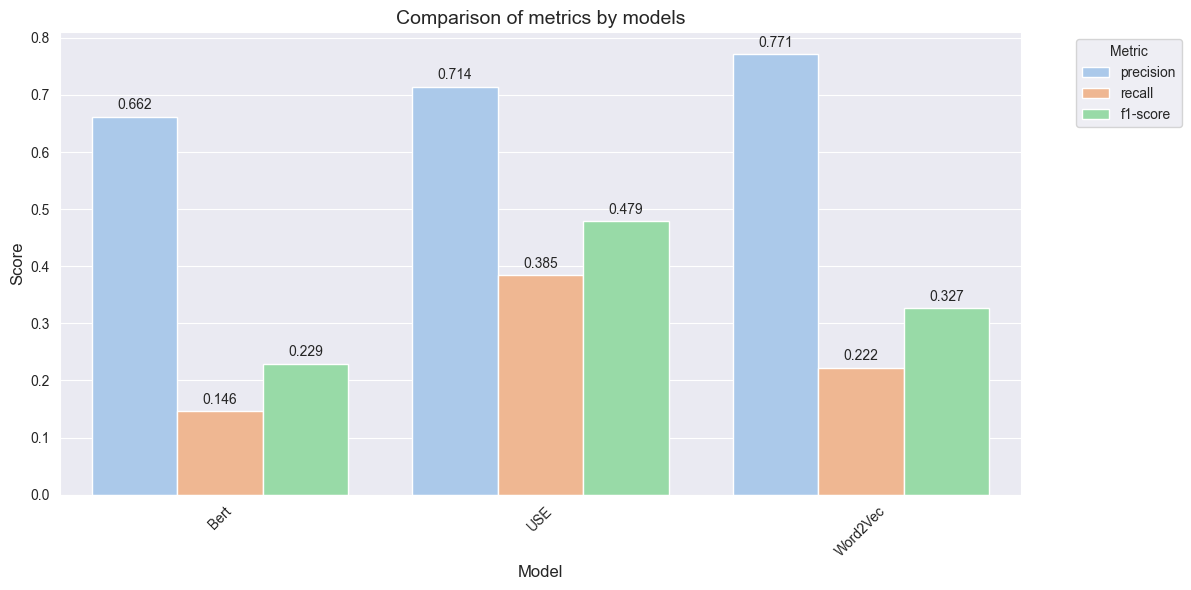

In [9]:
model_dfs_emb = {
    'Bert': bert_metrics,
    'USE': use_metrics,
    'Word2Vec': word_metrics
}

compare_models_metrics(model_dfs_emb)

# Conclusion

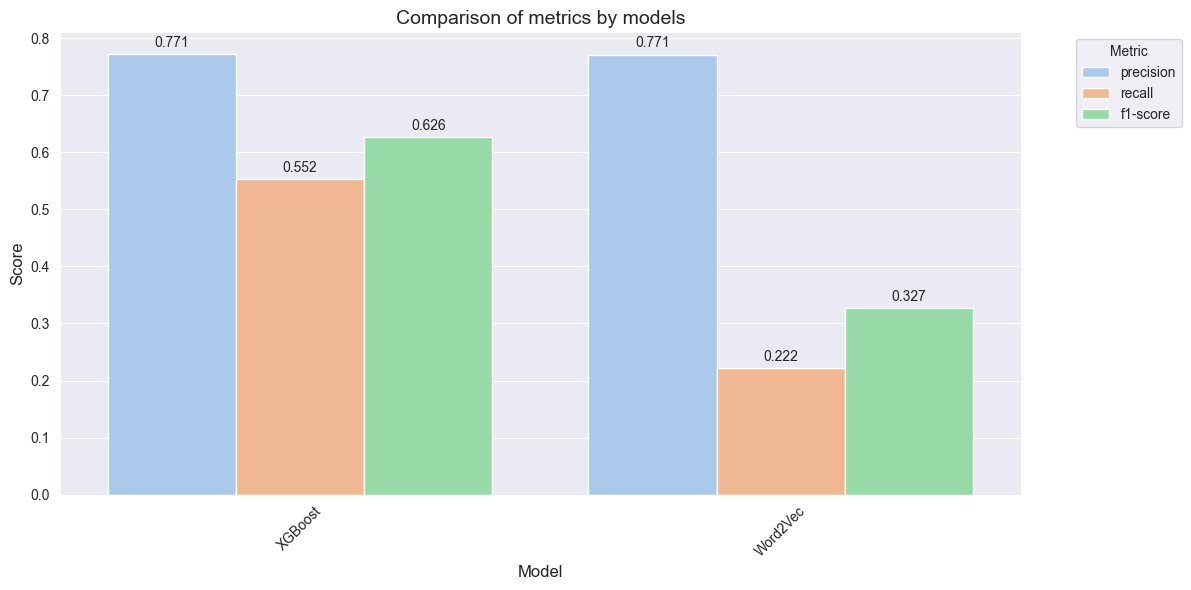

In [10]:
model_dfs_final = {
    'XGBoost': xg_boost_metrics,
    'Word2Vec': word_metrics
}

compare_models_metrics(model_dfs_final)

**XGBoost** was choosed because it achieves the highest precision and F1-score (weighted average) among all models, which is crucial when false positives are costly or when we prioritize correct predictions over completeness. Despite having slightly lower recall, XGBoost demonstrates strong overall performance, especially in capturing the most relevant classes with high confidence. Its efficiency and ability to handle complex patterns also make it a powerful model for supervised learning tasks.

n order to assess model stability before implementing real-time monitoring tools (e.g. Evidently AI), we simulate production drift analysis by comparing monthly performance over a one-year period. We compute key metrics (such as F1-scores) and analyze both data drift and concept drift across time intervals.

In [33]:
df = pd.read_csv('../data/data_clean_stackoverflow.csv')

In [34]:
df.head(2)

,text_clean,Tags,CreationDate
0,git submodule update fatal detect ownership re...,"['linux', 'filesystems', 'git', 'ubuntu']",2022-07-14 09:44:16
1,dataframe object attribute append append dicti...,"['pandas', 'concatenation', 'python', 'datafra...",2023-04-07 07:05:59


In [35]:
df['date'] = pd.to_datetime(df['CreationDate']) 
df['month'] = df['date'].dt.to_period('M')      

monthly_data = {
    str(month): df_month
    for month, df_month in df.groupby('month')
}

In [36]:
from sklearn.metrics import f1_score
import joblib

model_dir = '../models/final'

vectorizer = joblib.load(f'{model_dir}/vectorizer.pkl')
model = joblib.load(f'{model_dir}/model.pkl')
mlb = joblib.load(f'{model_dir}/mlb.pkl')

In [20]:
import ast

metrics_per_month = []
y_true_dict = {} # Создаем словарь для y_true
y_pred_dict = {} # Создаем словарь для y_pred

for month, df_month in monthly_data.items():
    df_month['Tags'] = df_month['Tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    X_month = vectorizer.transform(df_month['text_clean'])
    y_true_month = mlb.transform(df_month['Tags']) # Переименовали, чтобы избежать путаницы с общим y_true
    y_pred_month = model.predict(X_month)       # Переименовали, чтобы избежать путаницы с общим y_pred

    y_true_dict[month] = y_true_month # Сохраняем в словарь
    y_pred_dict[month] = y_pred_month # Сохраняем в словарь

    f1_micro = f1_score(y_true_month, y_pred_month, average='micro', zero_division=0)
    f1_samples = f1_score(y_true_month, y_pred_month, average='samples', zero_division=0)

    metrics_per_month.append({
        'month': month,
        'f1_micro': f1_micro,
        'f1_samples': f1_samples,
        'n_samples': len(df_month)
    })

In [32]:
import pandas as pd
from evidently import Report, Dataset, DataDefinition
from evidently.presets import DataDriftPreset, ClassificationPreset
from evidently import MulticlassClassification

# monthly_data — словарь вида {'2024-01': df_jan, '2024-02': df_feb, ...}
# y_true и y_pred — словари с numpy-массивами (shape: n_samples × n_labels)
# Берём один тег (пусть 0-ый) для классификации
def build_evidently_dataset(df_month, y_true_month, y_pred_month):
    df = pd.DataFrame({
        'text': df_month['text_clean'].values,
        'target': y_true_month[:, 0].astype(str),
        'prediction': y_pred_month[:, 0].astype(str),
    })
    # если были вероятности, их тоже можно добавить как float-колонки
    return df

ref_month = '2024-01'
ref_df = build_evidently_dataset(monthly_data[ref_month],
                                 y_true_dict[ref_month], y_pred_dict[ref_month])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
data_def = DataDefinition(
    text_columns=['text'],
    classification=[MulticlassClassification(
        target="target",
        prediction_labels="prediction"
        # prediction_probas можно указать при наличии вероятностей
    )]
)

In [ ]:
ref_ds = Dataset.from_pandas(ref_df, data_definition=data_def)
cur_month = '2024-02'  # пример
cur_df = build_evidently_dataset(monthly_data[cur_month],
                                 y_true_dict[cur_month], y_pred_dict[cur_month])

cur_ds = Dataset.from_pandas(cur_df, data_definition=data_def)

for month, df_m in monthly_data.items():
    if month == ref_month: continue

    cur_ds = Dataset.from_pandas(
        build_evidently_dataset(df_m, y_true_dict[month], y_pred_dict[month]),
        data_definition=data_def
    )

    report = Report([DataDriftPreset(), ClassificationPreset()])
    report.run(current_data=cur_ds, reference_data=ref_ds)
    report.save_html(f'report_drift_{month}.html')
    print(f'✅ report_drift_{month}.html created')